Utilizando los datos de los clientes realizar las siguientes actividades:

1. Analizar las variables involucradas

2. Armar el dataset, crear variables nuevas si es necesario

3.  Crear un modelo para predecir qué clientes responderán a la campaña (se adjuntan aparte los datos de la campaña 201804 para realizar el testing)

4. Indicar la performance del/los modelos creados

5. Describir el modelo y hacer una presentación para  mostrar los resultados al cliente




In [110]:
import pandas as pd
import numpy as np
#import re
#import random
import os

from datetime import date

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy import stats

import seaborn as sns

from google.colab import drive
#monto el gdrive
drive.mount('/content/gdrive/', force_remount=True)



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive/


In [0]:
os.chdir('gdrive/My Drive/MaestCienDatCAECE/2Año/MineriaDeDatosEmpresarial/Unidad_7_Mineria de datos para mkt y retail/Actividad_2')

In [0]:
!ls

#Data load - Clientes

In [0]:
#apunto el root al archivo a analizar
root_path ='gdrive/My Drive/MaestCienDatCAECE/2Año/MineriaDeDatosEmpresarial/Unidad_7_Mineria de datos para mkt y retail/Actividad_2/cliente.csv'
cliente_master = pd.read_csv(root_path, encoding="latin-1")

#apunto el root al archivo a analizar
root_path ='gdrive/My Drive/MaestCienDatCAECE/2Año/MineriaDeDatosEmpresarial/Unidad_7_Mineria de datos para mkt y retail/Actividad_2/camp.csv'
cliente_camp = pd.read_csv(root_path, encoding="latin-1")

#Data profile - Clientes

2. Armar el dataset, crear variables nuevas si es necesario


In [0]:
cliente_master_work = cliente_master.copy()
cliente_camp_work = cliente_camp.copy()

In [431]:
print("El data set de clientes tiene %d filas y %d columnas " % (cliente_master_work.shape[0],cliente_master_work.shape[1]))
print("El data set de campañas tiene %d filas y %d columnas " % (cliente_camp_work.shape[0],cliente_camp_work.shape[1]))

El data set de clientes tiene 21740 filas y 17 columnas 
El data set de campañas tiene 21740 filas y 3 columnas 


In [372]:
cliente_master_work.sort_values(by=['cid']).head(5)

,cid,monto_sucursal_1,monto_sucursal_2,monto_sucursal_3,monto_sucursal_4,promociones,dias_cliente,sucursales,promos_enviadas,promos_compras,produni,flagret,frecuencia_compra,estado,county,mid,fecha_nacimiento
0,55600018227,0.00,0.00,192.00,0.0,19,511,1,8,0,106.88,0,511.00,MN,550,1821001,01/28/72
1,55600021052,144.69,0.00,16.19,0.0,4,91,2,0,0,27.40,0,91.00,SC,290,284301,10/06/51
2,55600021210,0.00,141.29,138.60,0.0,15,657,2,5,1,12.74,1,82.12,CA,947,1679802,05/12/71
3,55600021232,0.00,0.00,380.18,0.0,24,384,3,7,2,35.49,0,96.00,AR,722,1726702,07/10/63
4,55600028433,0.00,623.24,230.23,0.0,18,694,2,11,3,24.35,1,99.14,MD,207,2109903,08/29/55


In [371]:
cliente_camp_work.sort_values(by=['cid']).head(5)

,cid,flag_incluido,flag_compro
5590,55600018227,1,0
5591,55600021052,1,0
5592,55600021210,0,0
5593,55600021232,0,0
5594,55600028433,1,0


In [0]:
#http://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/
#merge de los dataset por el cid
cliente_camp_join = pd.merge(cliente_master_work, cliente_camp_work, on='cid', how='inner')

In [383]:
#analizo completitud de datos para ver columnas a borrar o completar
x = cliente_camp_join.isna().sum()
if len(x[x>0])>0:
  d = {'NullRecord': x[x>0], 'TotalRecord': cliente_camp_join.shape[0]}
  y = pd.DataFrame(d)

  y["CompleteRecord"] = y["TotalRecord"] - y["NullRecord"]
  y["CompleteRecord_Rate"] = round((y["CompleteRecord"] / y["TotalRecord"] ) * 100,3)
  print(y.sort_values("NullRecord",ascending=True))
else:
  print("No hay registros vacios")

                  NullRecord  TotalRecord  CompleteRecord  CompleteRecord_Rate
fecha_nacimiento        1806        21740           19934               91.693


In [0]:
#borro el 10% de los registros en null
cliente_camp_join.dropna(axis=0,how='any',inplace=True)

In [77]:
#analizo completitud de datos para ver columnas a borrar o completar
x = cliente_camp_join.isna().sum()
if len(x[x>0])>0:
  d = {'NullRecord': x[x>0], 'TotalRecord': cliente_camp_join.shape[0]}
  y = pd.DataFrame(d)

  y["CompleteRecord"] = y["TotalRecord"] - y["NullRecord"]
  y["CompleteRecord_Rate"] = round((y["CompleteRecord"] / y["TotalRecord"] ) * 100,3)
  print(y.sort_values("NullRecord",ascending=True))
else:
  print("No hay registros vacios")

No hay registros vacios


In [0]:
cliente_camp_join['today'] = date.today().strftime('%Y-%m-%d')

cliente_camp_join["anio"] = "19"+cliente_camp_join.fecha_nacimiento.str[-2:]#.astype(int)
cliente_camp_join["mes"]  = cliente_camp_join.fecha_nacimiento.str[0:2]#.astype(int)
cliente_camp_join["dia"]  = cliente_camp_join.fecha_nacimiento.str[3:5]#.astype(int)

cliente_camp_join['fecha']= cliente_camp_join["anio"] + '/' + cliente_camp_join["mes"] + '/'+ cliente_camp_join["dia"]
cliente_camp_join["fecha"] = cliente_camp_join["fecha"].apply(pd.to_datetime)
cliente_camp_join["today"] = cliente_camp_join["today"].apply(pd.to_datetime)

In [0]:
#df['fecha']= str(df.fecha_nacimiento.str[3:5]+'/' + '19' + df.fecha_nacimiento.str[-2:])
cliente_camp_join['diff_days'] = cliente_camp_join['today']- cliente_camp_join['fecha']
cliente_camp_join['edad']=round(cliente_camp_join['diff_days']/np.timedelta64(1,'Y'),0).astype(int)

In [0]:
#consolido el importe
cliente_camp_join["importeTotal"] = cliente_camp_join["monto_sucursal_1"]+cliente_camp_join["monto_sucursal_2"]+cliente_camp_join["monto_sucursal_3"]+cliente_camp_join["monto_sucursal_4"]

In [0]:
#borro las columnas auxiliares de fechas
cliente_camp_join.drop(columns={"today","anio","mes","dia","diff_days"},axis=1,inplace=True)
#borro las columnas de importes parciales 
cliente_camp_join.drop(columns={"monto_sucursal_1","monto_sucursal_2","monto_sucursal_3","monto_sucursal_4"},axis=1,inplace=True)

In [84]:
cliente_camp_join.sort_values(by="cid").head()

,cid,promociones,dias_cliente,sucursales,promos_enviadas,promos_compras,produni,flagret,frecuencia_compra,estado,county,mid,fecha_nacimiento,flag_incluido,flag_compro,fecha,edad,importeTotal
0,55600018227,19,511,1,8,0,106.88,0,511.00,MN,550,1821001,01/28/72,1,0,1972-01-28,48,192.00
1,55600021052,4,91,2,0,0,27.40,0,91.00,SC,290,284301,10/06/51,1,0,1951-10-06,69,160.88
2,55600021210,15,657,2,5,1,12.74,1,82.12,CA,947,1679802,05/12/71,0,0,1971-05-12,49,279.89
3,55600021232,24,384,3,7,2,35.49,0,96.00,AR,722,1726702,07/10/63,0,0,1963-07-10,57,380.18
4,55600028433,18,694,2,11,3,24.35,1,99.14,MD,207,2109903,08/29/55,1,0,1955-08-29,65,853.47


# 1. Analizar las variables involucradas

In [109]:
print("El data set de clientes y campañas tiene %d filas y %d columnas " % (cliente_camp_join.shape[0],cliente_camp_join.shape[1]))

El data set de clientes y campañas tiene 19934 filas y 16 columnas 


In [95]:
print ("Registros con valores 0")
for i in cliente_camp_join.columns:
  if len(cliente_camp_join[cliente_camp_join[i]==0]) > 0 and i != "ClassVariable":
    print ("La columna ", i, " tiene ", len(cliente_camp_join[cliente_camp_join[i]==0]), 
           "Rate ",round((len(cliente_camp_join[cliente_camp_join[i]==0]) / cliente_camp_join.shape[0])*100,2) )

Registros con valores 0
La columna  promociones  tiene  755 Rate  3.79
La columna  promos_enviadas  tiene  3220 Rate  16.15
La columna  promos_compras  tiene  10719 Rate  53.77
La columna  flagret  tiene  13158 Rate  66.01
La columna  flag_incluido  tiene  6121 Rate  30.71
La columna  flag_compro  tiene  17670 Rate  88.64


In [98]:
x = cliente_camp_join.columns
for i in x:
  if cliente_camp_join[i].nunique()==cliente_camp_join.shape[0]:
    print ("la columna ",i," tiene todos los valores unicos")


la columna  cid  tiene todos los valores unicos
la columna  mid  tiene todos los valores unicos


In [0]:
cliente_camp_join.drop(columns={"cid","mid"},axis=1,inplace=True)

In [0]:
x = cliente_camp_join.columns
for i in x:
  if cliente_camp_join[i].nunique()==cliente_camp_join.shape[0]:
    print ("la columna ",i," tiene todos los valores unicos")

In [108]:
cliente_camp_join.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
promociones,19934.0,11.578308,7.152780,0.00,5.00,12.00,17.0000,38.00
dias_cliente,19934.0,437.888231,193.080493,1.00,287.00,447.00,630.0000,713.00
sucursales,19934.0,2.341928,1.605680,1.00,1.00,2.00,3.0000,19.00
promos_enviadas,19934.0,4.673021,3.548693,0.00,1.00,4.00,8.0000,11.00
promos_compras,19934.0,1.194442,1.828501,0.00,0.00,0.00,2.0000,11.00
produni,19934.0,37.787458,28.073033,0.05,18.37,29.36,50.0000,200.00
flagret,19934.0,0.339922,0.473694,0.00,0.00,0.00,1.0000,1.00
frecuencia_compra,19934.0,170.390849,145.984852,1.00,67.00,123.00,229.0000,713.00
county,19934.0,405.892545,304.887472,10.00,128.00,334.00,639.7500,999.00
flag_incluido,19934.0,0.692937,0.461287,0.00,0.00,1.00,1.0000,1.00


In [0]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.style.use('ggplot')

In [0]:
sns.boxplot(x=cliente_camp_join["importeTotal"])


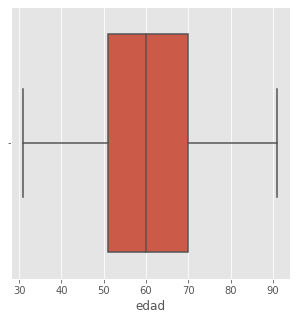

In [188]:
sns.boxplot(x=cliente_camp_join["edad"])


In [0]:
#https://seaborn.pydata.org/generated/seaborn.countplot.html
sns.countplot(x = 'flag_incluido',
              data = cliente_camp_join)

In [0]:
sns.countplot(x = 'flag_compro',
              data = cliente_camp_join)

In [0]:
sns.countplot(x = 'flag_compro',
              data = cliente_camp_join[cliente_camp_join["flag_incluido"]==1])

In [0]:
sns.catplot(x="flag_incluido", 
            #hue="who", 
            col="flag_compro",
            data=cliente_camp_join, 
            kind="count",
            height=4, 
            aspect=.7);

In [395]:
print('Group sum every Terms in Data')
print(cliente_camp_join.groupby('flag_incluido')['flag_compro'].value_counts())

Group sum every Terms in Data
flag_incluido  flag_compro
0              0               6669
1              0              12606
               1               2465
Name: flag_compro, dtype: int64


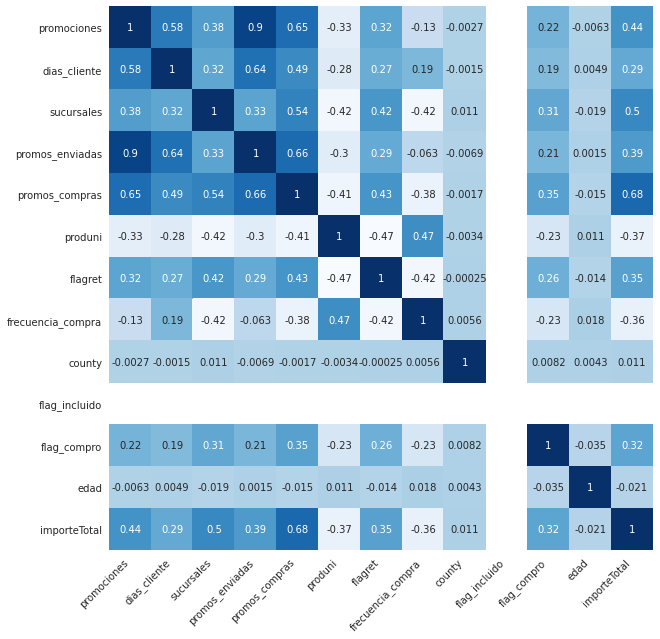

In [151]:
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
c= cliente_camp_join[cliente_camp_join["flag_incluido"]==1].corr()
mask = np.zeros_like(c)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(c, square=True,cmap="Blues",annot=True,cbar=False)
    #ax = sns.heatmap(c, mask=mask, vmax=.3, square=True,cmap="Blues",annot=True,cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

#3. Crear un modelo para predecir qué clientes responderán a la campaña (se adjuntan aparte los datos de la campaña 201804 para realizar el testing)

##Arbol de desición

In [0]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [0]:
cliente_camp_join_tree = cliente_camp_join[cliente_camp_join["flag_incluido"]==1]

In [398]:
cliente_camp_join_tree.drop(columns={"flag_incluido"},axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
c= cliente_camp_join_tree.corr()
mask = np.zeros_like(c)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15,10))
    ax = sns.heatmap(c, square=True,cmap="Blues",annot=True,cbar=False)
    #ax = sns.heatmap(c, mask=mask, vmax=.3, square=True,cmap="Blues",annot=True,cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

In [156]:
cliente_camp_join_tree.columns

Index(['promociones', 'dias_cliente', 'sucursales', 'promos_enviadas',
       'promos_compras', 'produni', 'flagret', 'frecuencia_compra', 'estado',
       'county', 'fecha_nacimiento', 'flag_compro', 'fecha', 'edad',
       'importeTotal'],
      dtype='object')

In [0]:
feature_cols = ['importeTotal', 'flagret', 'promos_compras','promos_enviadas',
                'sucursales','promociones']
X = cliente_camp_join_tree[feature_cols] # Features
y = cliente_camp_join_tree['flag_compro'] # Target variable

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.25) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=2)

# Train Decision Tree Classifer
clf = clf.fit(X_train_t,y_train_t)

#Predict the response for test dataset
y_pred_t = clf.predict(X_test_t)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_t, y_pred_t))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [0]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

cm_t = confusion_matrix(y_test_t, y_pred_t)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(cm_t, 
                     square=True,
                     cmap="Blues",
                     annot=True,
                     fmt="d",
                     cbar=False)
    #ax = sns.heatmap(c, mask=mask, vmax=.3, square=True,cmap="Blues",annot=True,cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    #ax.set_xticklabels({"negative","positive"}, rotation=0, horizontalalignment='right')
    #ax.set_yticklabels({"negative","positive"}, rotation=0, horizontalalignment='right')

plt.show()

In [0]:
 tn, fp, fn, tp = cm_t.ravel()

In [422]:
fn

473

In [0]:
feature_cols = [ 'flagret', 'promos_compras','promos_enviadas',
                'sucursales','promociones']
X = cliente_camp_join_tree[feature_cols] # Features
y = cliente_camp_join_tree['flag_compro'] # Target variable

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.25) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train_t,y_train_t)

#Predict the response for test dataset
y_pred_t = clf.predict(X_test_t)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_t, y_pred_t))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [0]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

cm_t = confusion_matrix(y_test_t, y_pred_t)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(cm_t, 
                     square=True,
                     cmap="Blues",
                     annot=True,
                     fmt="d",
                     cbar=False)
    #ax = sns.heatmap(c, mask=mask, vmax=.3, square=True,cmap="Blues",annot=True,cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    #ax.set_xticklabels({"negative","positive"}, rotation=0, horizontalalignment='right')
    #ax.set_yticklabels({"negative","positive"}, rotation=0, horizontalalignment='right')

plt.show()

##Redes neuronales

In [0]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [0]:
cliente_camp_join_NN = pd.DataFrame({#'importeTotal':cliente_camp_join['importeTotal'],
                                 'flagret':cliente_camp_join['flagret'],
                                 'promos_compras':cliente_camp_join['promos_compras'],
                                 'promos_enviadas':cliente_camp_join['promos_enviadas'],
                                 'sucursales':cliente_camp_join['sucursales'],
                                 'promociones':cliente_camp_join['promociones'],
                                 'flag_compro':cliente_camp_join['flag_compro']
                                 #'ClassVariable':diabetes_clear_0['ClassVariable']
                                  }) 

In [0]:
# split into input (X) and output (y) variables
X = cliente_camp_join_NN.drop('flag_compro',axis=1)
y = cliente_camp_join_NN['flag_compro']

In [0]:
#hago el split en grupo de entrenamiento y test
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlpclassifier#sklearn.neural_network.MLPClassifier
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                y, 
                                                #train_size=0.80,
                                                test_size=0.25
                                                )

In [0]:
clf = MLPClassifier(hidden_layer_sizes=(6,200,50), 
                    max_iter=200, 
                    #alpha=0.0001,
                    solver='sgd', 
                    #verbose=10,  
                    #random_state=21,
                    #tol=0.000000001
                    )

In [0]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [417]:
accuracy_score(y_test, y_pred)

0.886292548298068

In [418]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[4814,    1],
       [ 617,    3]])

In [0]:
sns.heatmap(cm, center=True)
plt.show()

In [0]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5,5))
    ax = sns.heatmap(cm, 
                     square=True,
                     cmap="Blues",
                     annot=True,
                     fmt="d",
                     cbar=False)
    #ax = sns.heatmap(c, mask=mask, vmax=.3, square=True,cmap="Blues",annot=True,cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    #ax.set_xticklabels({"negative","positive"}, rotation=0, horizontalalignment='right')
    #ax.set_yticklabels({"negative","positive"}, rotation=0, horizontalalignment='right')

plt.show()

#4. Indicar la performance del/los modelos creados

Si solo se evalua la "Accuracy" de los modelos, performa mejor la red neurona con 88 vs 84 del arbol.

Pero el evaluar la matriz de confusion performa mejor el arbol, dado que tiene mas TP que la red, si bien ambos son malos, el arbol es menos malo.

por el analisis de las variables se observan muy pocos casos que respondieran al estimulo de la promoción, entonces la distribución esta muy desbalanceada y tiene mas cantidad de resultados desfavorables que el buscado.